In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Load data & resources

In [2]:
# ISO 639 table for full language names
iso_639_3_names = pd.read_csv("data/iso-639-3_Name_Index.tab.txt", delimiter="\t", index_col=0)
iso_639_3_names = iso_639_3_names["Print_Name"].to_dict()
iso_639_3_names["cmn"] = "Chinese"
# iso_639_3_names

In [3]:
# sentences for evaluating predicted language
df = pd.read_csv("data/sentences.csv", delimiter="\t", header=None, index_col=0, names=["Language", "Sentence"])

## Get counts of sentences by language

In [4]:
language_counts = df["Language"].value_counts(normalize=False)
language_counts = language_counts.to_frame().reset_index()
language_counts.rename(columns={"index":"ISO Name", "Language": "Count"}, inplace=True)
language_counts["Full Name"] = language_counts["ISO Name"].map(iso_639_3_names)
language_counts = language_counts[["ISO Name", "Full Name", "Count"]]

## Identify languages with > 5,000 sentences

In [5]:
over_5k = language_counts[language_counts["Count"]>5000]
over_5k_list = over_5k["ISO Name"].tolist()
# over_5k_list # list of "ISO Name" str

## Check which common PKI languages are included in sentences

In [6]:
PKI_LANGUAGES = [
    "English",
    "Chinese",
    "German",
    "Spanish",
    "French",
    "Italian",
    "Japanese",
    "Korean",
    "Portuguese",
    "Danish",
    "Dutch", # no Dutch in sentences?
    "Norwegian", # no Norwegian in sentences?
]

found_PKI_LANGUAGES = over_5k[over_5k["Full Name"].isin(PKI_LANGUAGES)]
# found_PKI_LANGUAGES

set(PKI_LANGUAGES).difference(set(found_PKI_LANGUAGES["Full Name"]))

{'Dutch', 'Norwegian'}

> sentences are missing Dutch & Norwegian.

## Limit to languages with over 5,000 sentences & that are common at PKI

In [7]:
sentences_over_5k = df[df["Language"].isin(over_5k_list)]
sentences_over_5k["Language Full Name"] = sentences_over_5k["Language"].map(iso_639_3_names)
sentences_over_5k = sentences_over_5k[sentences_over_5k["Language Full Name"].isin(PKI_LANGUAGES)]
sentences_over_5k = sentences_over_5k[["Sentence", "Language", "Language Full Name"]]

## Create a random stratified sample of 10,000 sentences

In [8]:
max_sample_size = int(sentences_over_5k["Language Full Name"].value_counts(normalize=False).min() / 1000) * 1000 # use the smallest language group to set uniform sample size across all languages
# max_sample_size

In [9]:
sample = sentences_over_5k.groupby("Language Full Name", group_keys=False).apply(lambda x: x.sample(max_sample_size))

# Get predicted languages from langid

In [10]:
from langid.langid import LanguageIdentifier, model

In [11]:
lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
lang_identifier.set_languages([
    'en', # English
    'zh', # Chinese
    'de', # German
    'es', # Spanish
    'fr', # French
    'it', # Italian
    'ja', # Japanese
    'ko', # Korean
    'pt', # Portuguese
    'da', # Danish
#     'nl', # Dutch; not included in sentences so remove
#     'no'  # Norwegian; not included in sentences so remove
])

In [12]:
sample["langid"] = sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)
sample["langid_language"], sample["langid_score"] = sample["langid"].str
sample.drop(columns=["langid"], inplace=True)

In [13]:
iso_639_1_names = pd.read_csv("data/iso639-1.tsv", delimiter="\t", usecols=["code", "Label (English)"])
iso_639_1_names.rename(columns={"code":"ISO Name", "Label (English)": "Full Name"}, inplace=True)
iso_639_1_names.set_index("ISO Name", inplace=True)
iso_639_1_names = iso_639_1_names["Full Name"].to_dict()
iso_639_1_names["es"] = "Spanish"
iso_639_1_names["nl"] = "Dutch"
# iso_639_1_names["zh"] = "Mandarin Chinese"

In [14]:
sample["langid_language Full Name"] = sample["langid_language"].map(iso_639_1_names)

In [15]:
# sample["langid_language Full Name"].value_counts()[:30]

## Evaluate results

In [16]:
pd.crosstab(sample["Language Full Name"], sample["langid_language Full Name"])

langid_language Full Name,Chinese,Danish,English,French,German,Italian,Japanese,Korean,Portuguese,Spanish
Language Full Name,,,,,,,,,,
Chinese,6642,0,1,0,0,0,357,0,0,0
Danish,0,6696,116,64,85,9,0,0,2,28
English,0,16,6878,24,40,10,0,0,6,26
French,4,9,71,6729,19,60,0,0,39,69
German,0,9,63,21,6897,4,0,0,2,4
Italian,5,12,177,85,38,6448,0,0,84,151
Japanese,2,0,0,0,0,0,6998,0,0,0
Korean,1,0,0,0,0,0,0,6998,0,1
Portuguese,0,7,66,208,22,100,1,0,6186,410


In [17]:
from sklearn.metrics import classification_report

In [18]:
labels = sentences_over_5k["Language Full Name"].unique().tolist()
# labels

In [19]:
print(classification_report(sample["Language Full Name"], sample["langid_language Full Name"], target_names=labels))

              precision    recall  f1-score   support

     Chinese       1.00      0.95      0.97      7000
      German       0.99      0.96      0.97      7000
      French       0.93      0.98      0.95      7000
     English       0.92      0.96      0.94      7000
    Japanese       0.97      0.99      0.98      7000
     Spanish       0.96      0.92      0.94      7000
     Italian       0.95      1.00      0.97      7000
      Korean       1.00      1.00      1.00      7000
  Portuguese       0.95      0.88      0.91      7000
      Danish       0.90      0.92      0.91      7000

    accuracy                           0.96     70000
   macro avg       0.96      0.96      0.96     70000
weighted avg       0.96      0.96      0.96     70000



In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [21]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

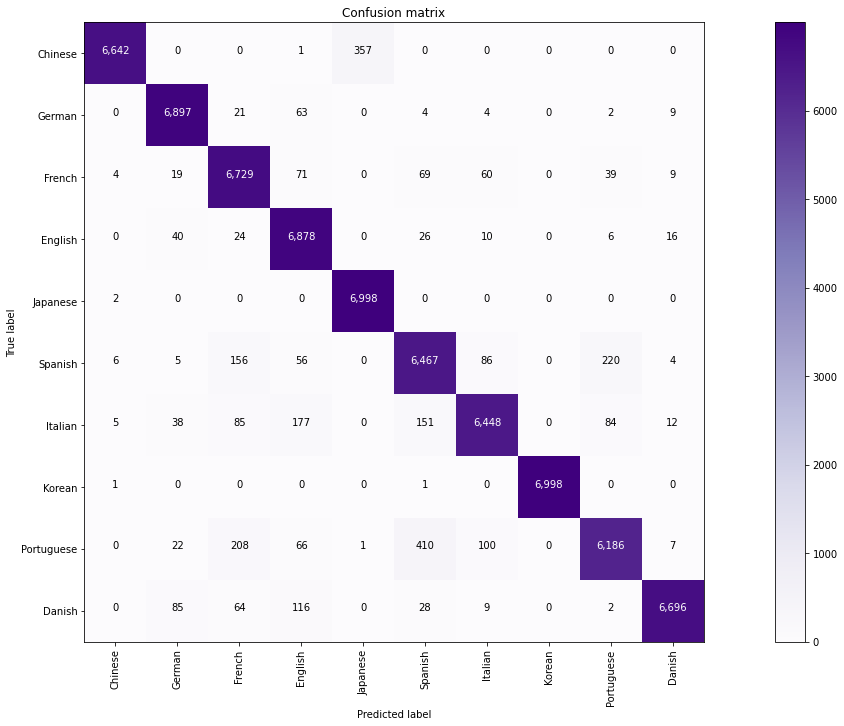

In [23]:
cm = confusion_matrix(sample["Language Full Name"], sample["langid_language Full Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

## Test performance as function of sentence length

In [24]:
import re

def get_sentence_char_len(thisRow: pd.Series) -> int:
    this_language = thisRow["Language Full Name"]
    this_text = thisRow["Sentence"]
    # remove punctuation from this_text
    this_text = re.sub(r"[。？?！!，.“”、「」]", "", this_text) # the pattern is just a number of punctuations I found in the Asian texts
    
    if this_language in ["Chinese", "Japanese", "Korean"]:
        result = len(this_text)
    else:
        result = len(this_text.split())
        
    return result

In [25]:
sentences_over_5k["Sentence_char_len"] = sentences_over_5k.apply(lambda x: get_sentence_char_len(x), axis=1)

In [26]:
sample = sentences_over_5k[sentences_over_5k["Sentence_char_len"]<201] # only work with sentences of 200 chars max

In [27]:
bin_labels = ["1","2","3","4","5","6","7","8","9","10","11 to 16", "17 to 27", "28 to 48", "49 to 99", "100 to 200"]

sample["bin"] = pd.cut(
    x=sentences_over_5k["Sentence_char_len"],
    bins=[0,1,2,3,4,5,6,7,8,9,10,16,27,48,99,200],
    labels=bin_labels
)

In [28]:
from sklearn.metrics import f1_score

In [29]:
results = []
for this_bin in bin_labels:
    print(this_bin)
    
    for i in range(0,100):        
        temp_sample = sample[sample["bin"]==this_bin]
        # find max sample size
        max_sample_size = temp_sample["Language Full Name"].value_counts(normalize=False).min()
        this_sample = temp_sample.groupby("Language Full Name", group_keys=False).apply(lambda x: x.sample(max_sample_size))

        this_sample["langid"] = this_sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)
        this_sample["langid_language"], this_sample["langid_score"] = this_sample["langid"].str
        this_sample.drop(columns=["langid"], inplace=True)
        this_sample["langid_language Full Name"] = this_sample["langid_language"].map(iso_639_1_names)

        these_labels = this_sample["Language Full Name"].unique().tolist()

        for lang in this_sample["langid_language Full Name"].unique():
            these_results = this_sample[this_sample["langid_language Full Name"]==lang]

            this_f1 = f1_score(these_results["Language Full Name"], these_results["langid_language Full Name"], labels=these_labels, average="weighted")
            result = (this_bin, lang, round(this_f1,2))
            results.append(result)

1
2
3
4
5
6
7
8
9
10
11 to 16
17 to 27
28 to 48
49 to 99
100 to 200


### Plot results

In [30]:
import seaborn as sns

In [31]:
# TODO: address inconsistent sample sizes (?)

In [59]:
results = pd.DataFrame(data=results, columns=["Bin", "Language", "F1"])
results_pivot = results.pivot_table(values="F1", index="Language", columns="Bin")
results_pivot = results_pivot[bin_labels]
results_pivot.loc["Average"] = results_pivot.mean()

In [60]:
# create custom colormap for consistent colors
language_cmap = {}
language_cmap["Average"] = (0.8901960784313725, 0.10196078431372549, 0.10980392156862745) # red-orange

language_cmap["Chinese"] = (0.5545098039215688, 0.7564167627835449, 0.8683121876201461) # blue
language_cmap["Japanese"] = (0.21568627450980393, 0.5294117647058824, 0.7542483660130719) # blue
language_cmap["Korean"] = (0.06251441753171857, 0.35750865051903113, 0.6429065743944637) # blue

language_cmap["French"] = (0.5739331026528259, 0.8241753171856978, 0.5606151480199923) # green
language_cmap["Italian"] = (0.21568627450980393, 0.6287581699346405, 0.3333333333333333) # green
language_cmap["Spanish"] = (0.04359861591695502, 0.4648212226066897, 0.20369088811995384) # green
language_cmap["Portuguese"] = (0.7792233756247597, 0.9132333717800846, 0.7518031526336024) # green

language_cmap["English"] = (0.698961937716263, 0.6965013456362938, 0.8372164552095348) # purple
language_cmap["Danish"] = (0.47320261437908495, 0.43267973856209146, 0.6993464052287581) # purple
language_cmap["German"] = (0.3568166089965398, 0.20525951557093425, 0.5856978085351787) # purple

# create custom dash dict for consistent dashes
language_dashes = {}
language_dashes["Average"] = (1, 1)

language_dashes["Chinese"] = (2, 1)
language_dashes["Japanese"] = (4, 3)
language_dashes["Korean"] = (6, 6)

language_dashes["French"] = (2, 1)
language_dashes["Italian"] = (4, 3)
language_dashes["Spanish"] = (6, 6)
language_dashes["Portuguese"] = (8, 12)

language_dashes["English"] = (2, 1)
language_dashes["Danish"] = (4, 3)
language_dashes["German"] = (6, 6)

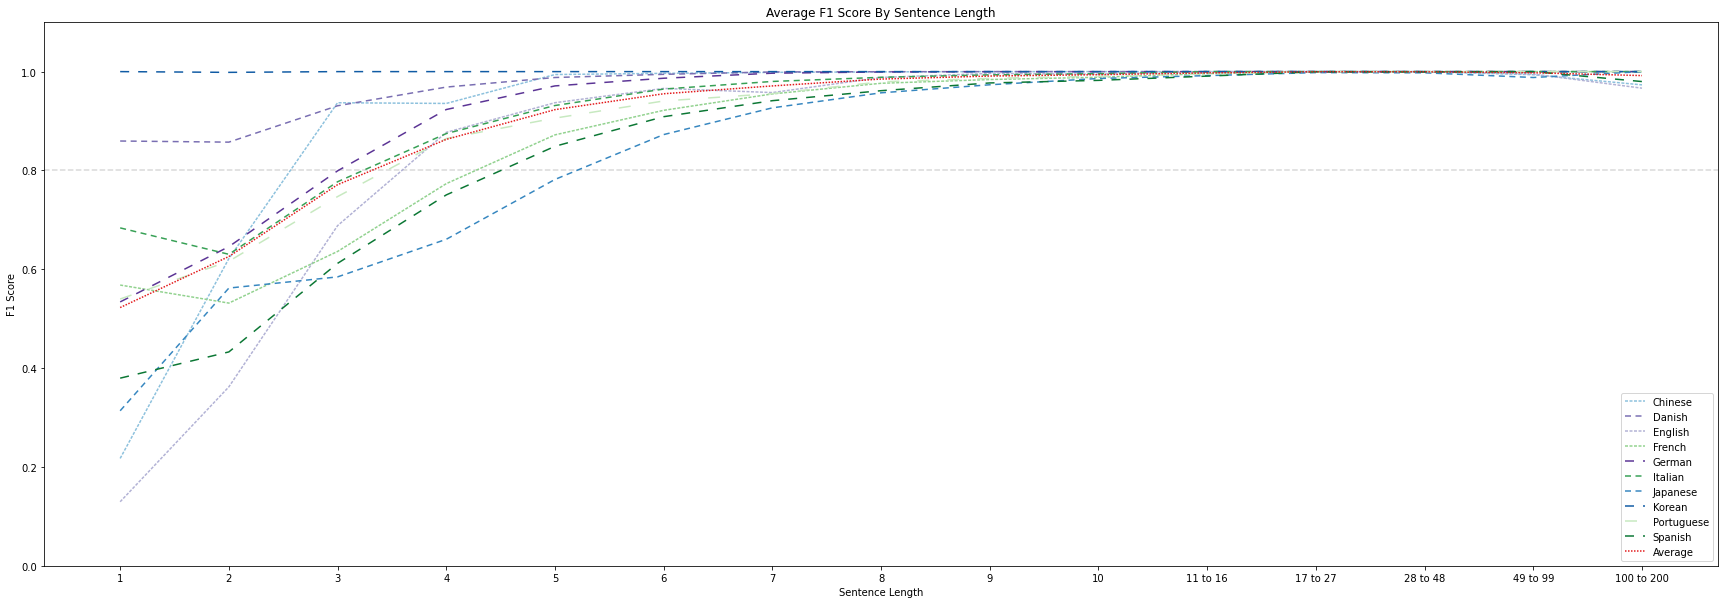

In [61]:
# ax = results_pivot.T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

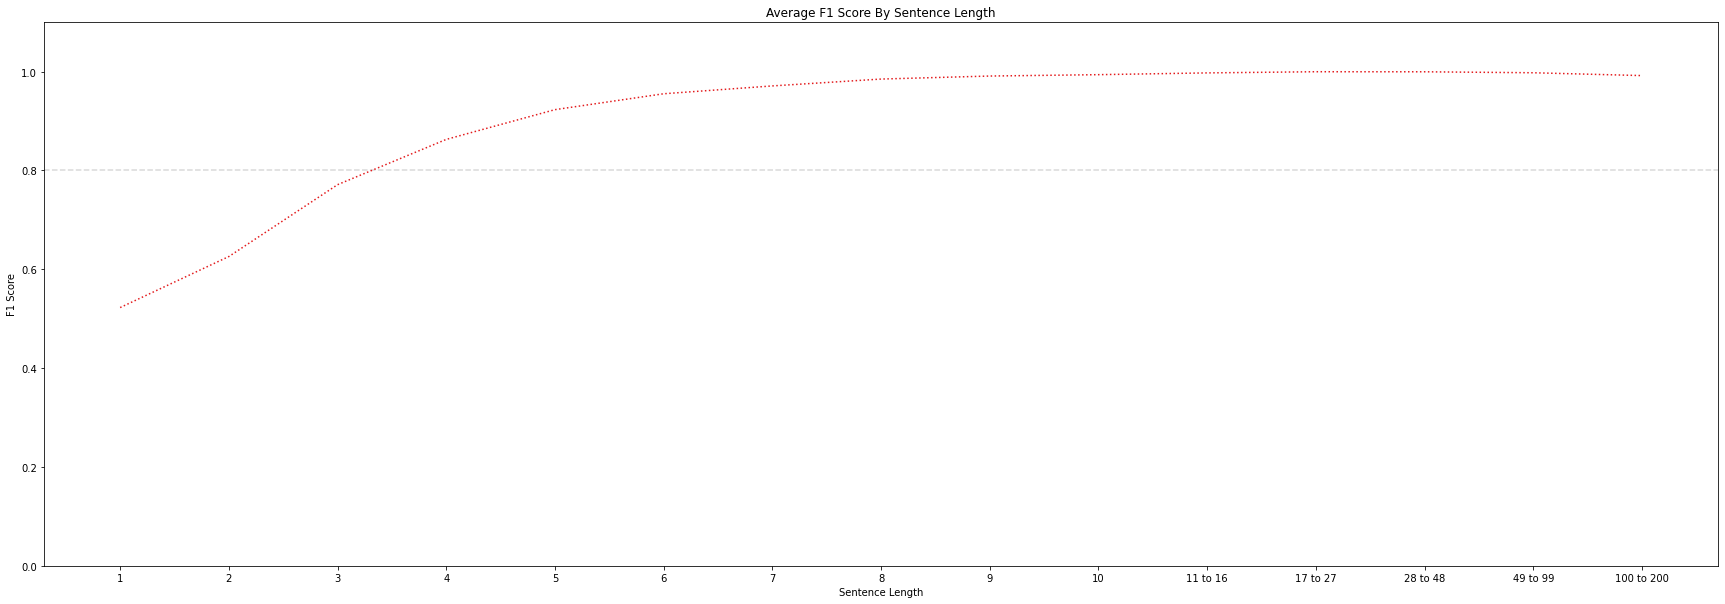

In [62]:
# ax = results_pivot.loc["Average"].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc["Average"].T, color=language_cmap["Average"], linestyle="dotted");
# plt.legend(loc="lower right");

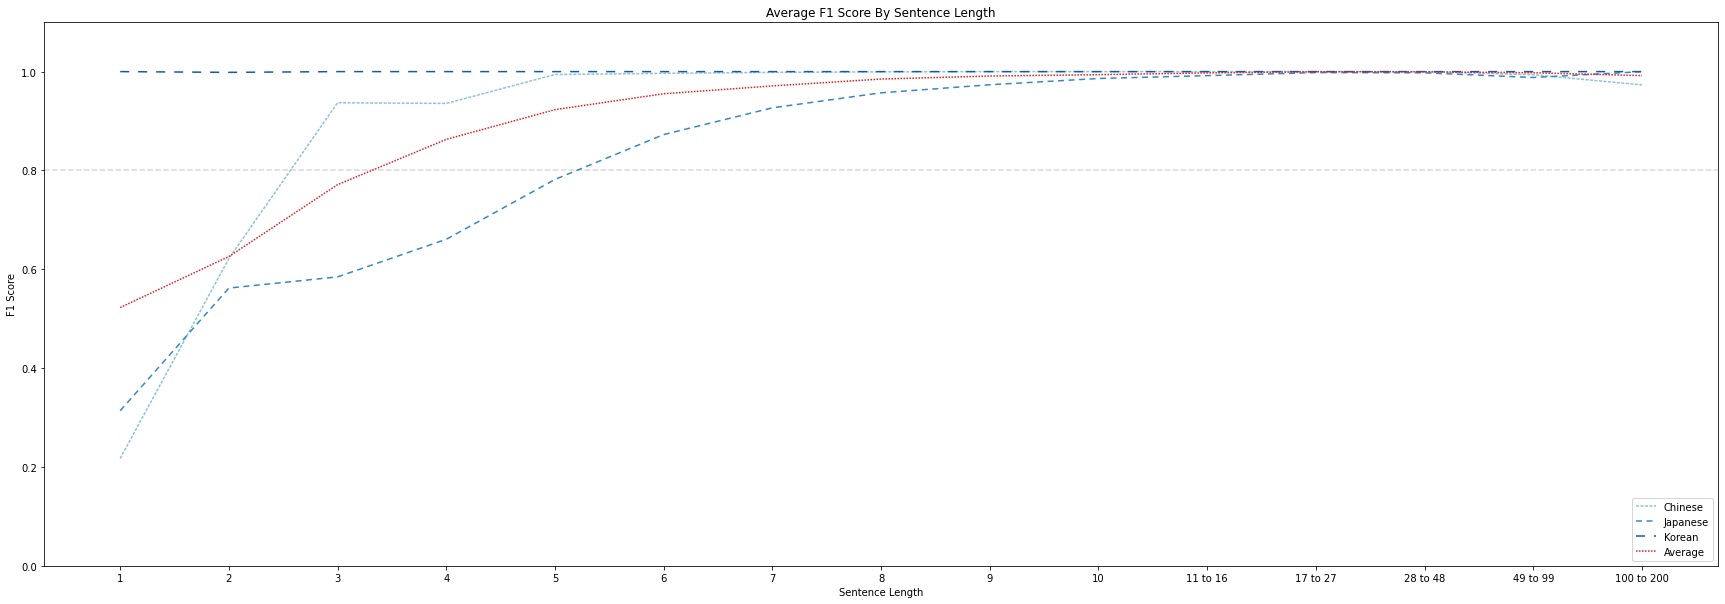

In [63]:
THESE_LANGUAGES = ["Chinese", "Japanese", "Korean"]
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

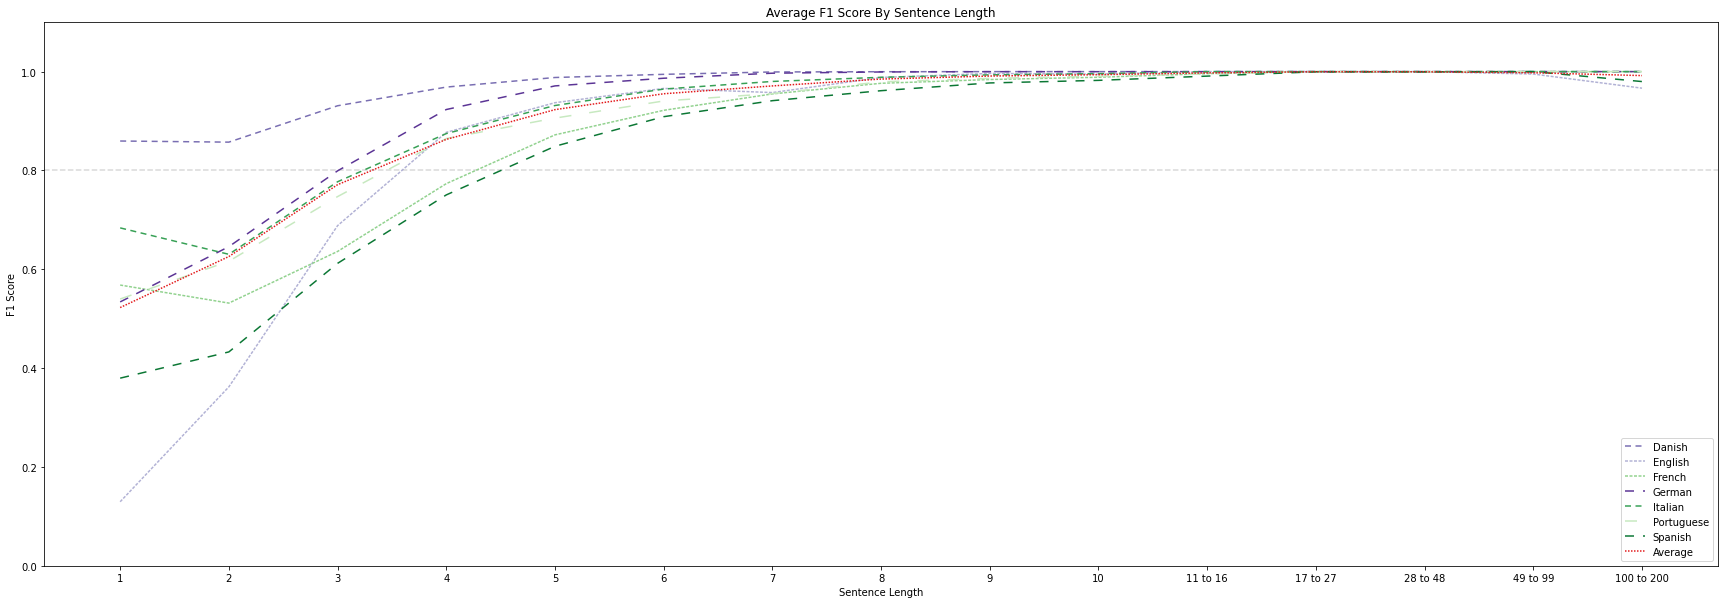

In [64]:
THESE_LANGUAGES = ['Danish', 'English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

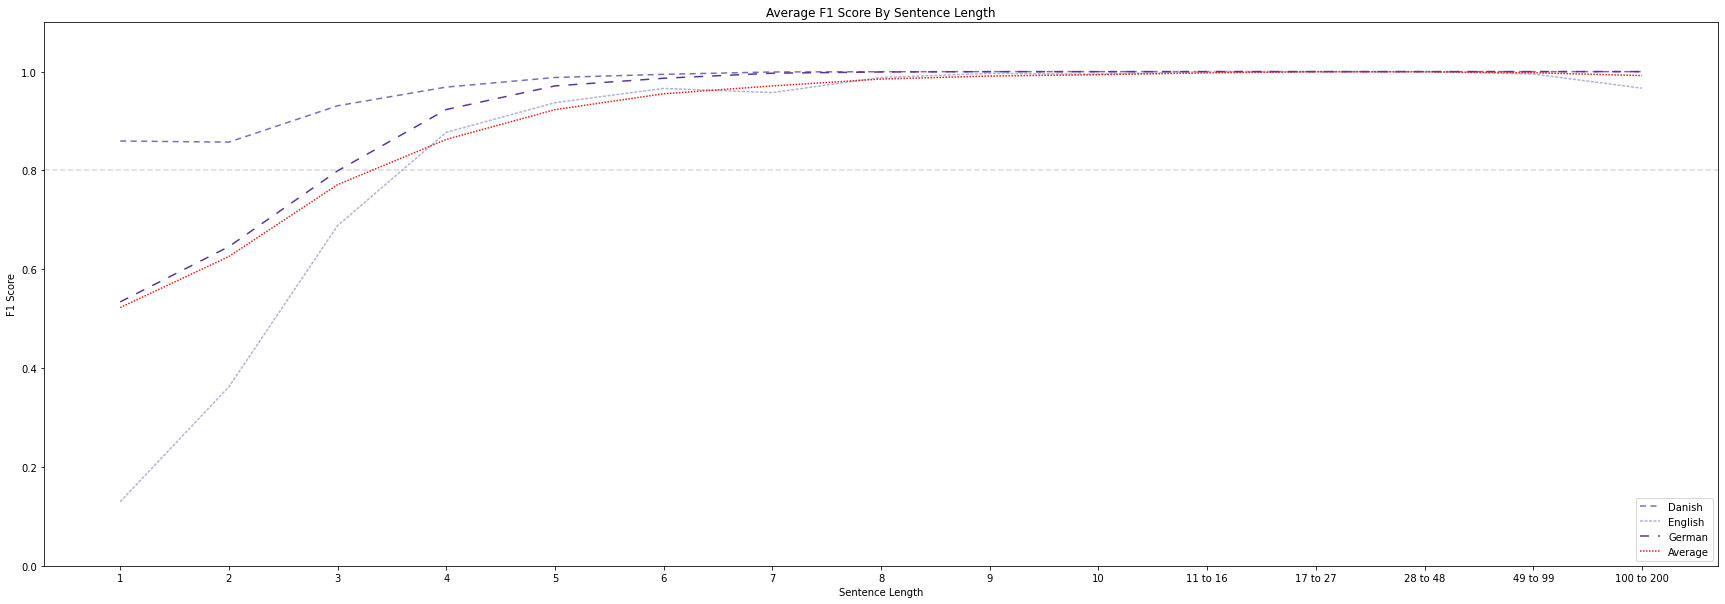

In [65]:
THESE_LANGUAGES = ['Danish', 'English', 'German']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

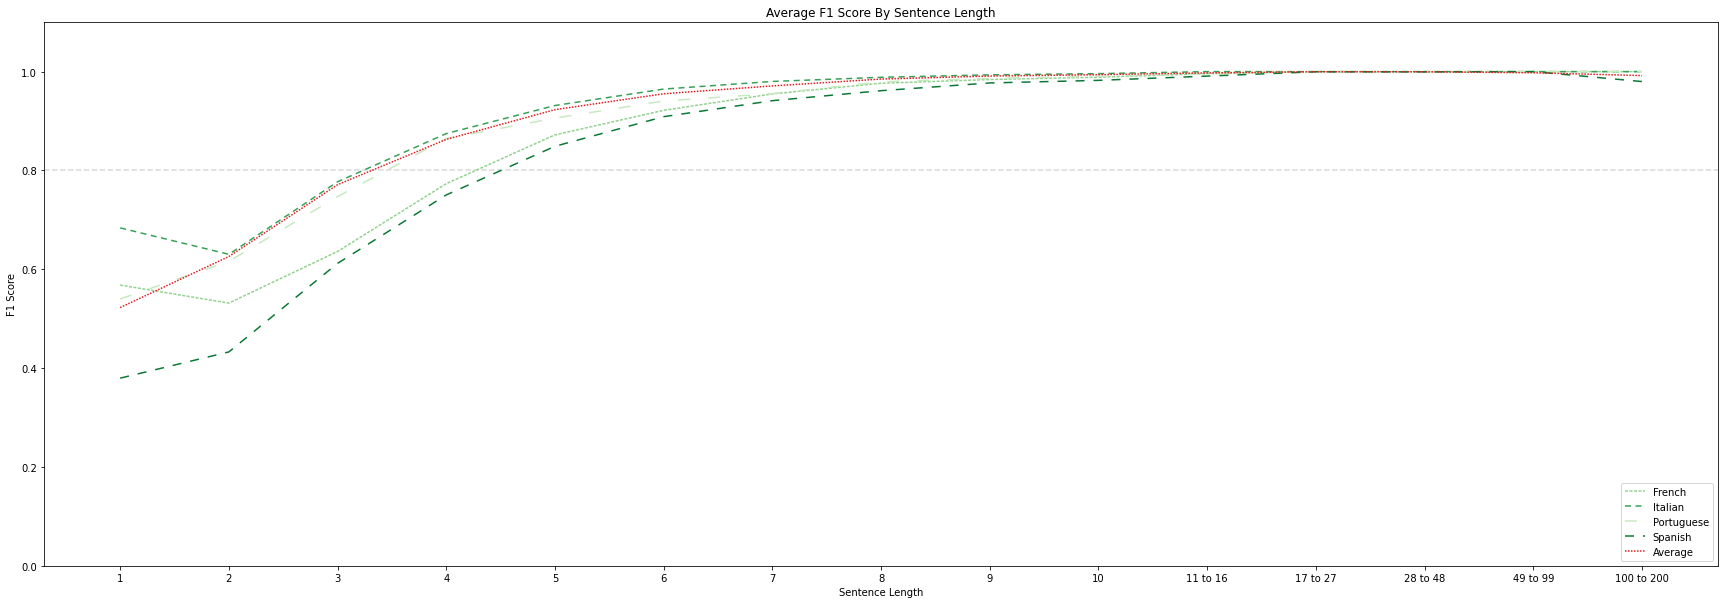

In [66]:
THESE_LANGUAGES = ['French', 'Italian', 'Portuguese', 'Spanish']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [67]:
# number of chars needed to be above 0.8 F1

In [68]:
results_pivot

Bin,1,2,3,4,5,6,7,8,9,10,11 to 16,17 to 27,28 to 48,49 to 99,100 to 200
Language,,,,,,,,,,,,,,,
Chinese,0.217300,0.62170,0.93700,0.93560,0.99410,0.9965,0.99850,0.99950,1.00000,1.00000,1.0000,1.00000,0.99990,0.99370,0.97320
Danish,0.859565,0.85730,0.93090,0.96870,0.98810,0.9945,0.99930,0.99980,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000
English,0.129600,0.36210,0.68830,0.87710,0.93710,0.9660,0.95760,0.98820,0.99630,0.99500,1.0000,1.00000,1.00000,0.99510,0.96650
French,0.568100,0.53160,0.63610,0.77330,0.87200,0.9217,0.95490,0.97640,0.98400,0.98860,0.9959,1.00000,0.99980,1.00000,1.00000
German,0.534000,0.64580,0.79920,0.92330,0.97110,0.9866,0.99680,0.99930,0.99990,0.99990,1.0000,1.00000,1.00000,1.00000,1.00000
Italian,0.683789,0.63030,0.77710,0.87460,0.93140,0.9647,0.98010,0.98850,0.99350,0.99590,1.0000,1.00000,1.00000,1.00000,1.00000
Japanese,0.313700,0.56200,0.58460,0.66070,0.78180,0.8726,0.92670,0.95710,0.97340,0.98610,0.9919,0.99800,0.99760,0.98810,1.00000
Korean,1.000000,0.99850,1.00000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000
Portuguese,0.539880,0.61630,0.74710,0.86460,0.90590,0.9406,0.95550,0.97930,0.98640,0.99050,0.9953,1.00000,0.99980,1.00000,1.00000


In [69]:
# find the first bin where average F1 exceeds 0.8 & stays above 0.8 for the remainder

In [72]:
_80 = results_pivot.apply(lambda row: row[row > 0.79].index[0], axis=1)
_90 = results_pivot.apply(lambda row: row[row > 0.89].index[0], axis=1)
results_pivot["First Bin >= 0.8"] = _80
results_pivot["First Bin >= 0.9"] = _90
results_pivot

Bin,1,2,3,4,5,6,7,8,9,10,11 to 16,17 to 27,28 to 48,49 to 99,100 to 200,First Bin >= 0.8,First Bin >= 0.9
Language,,,,,,,,,,,,,,,,,
Chinese,0.217300,0.62170,0.93700,0.93560,0.99410,0.9965,0.99850,0.99950,1.00000,1.00000,1.0000,1.00000,0.99990,0.99370,0.97320,3,3
Danish,0.859565,0.85730,0.93090,0.96870,0.98810,0.9945,0.99930,0.99980,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1,3
English,0.129600,0.36210,0.68830,0.87710,0.93710,0.9660,0.95760,0.98820,0.99630,0.99500,1.0000,1.00000,1.00000,0.99510,0.96650,4,5
French,0.568100,0.53160,0.63610,0.77330,0.87200,0.9217,0.95490,0.97640,0.98400,0.98860,0.9959,1.00000,0.99980,1.00000,1.00000,5,6
German,0.534000,0.64580,0.79920,0.92330,0.97110,0.9866,0.99680,0.99930,0.99990,0.99990,1.0000,1.00000,1.00000,1.00000,1.00000,3,4
Italian,0.683789,0.63030,0.77710,0.87460,0.93140,0.9647,0.98010,0.98850,0.99350,0.99590,1.0000,1.00000,1.00000,1.00000,1.00000,4,5
Japanese,0.313700,0.56200,0.58460,0.66070,0.78180,0.8726,0.92670,0.95710,0.97340,0.98610,0.9919,0.99800,0.99760,0.98810,1.00000,6,7
Korean,1.000000,0.99850,1.00000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1,1
Portuguese,0.539880,0.61630,0.74710,0.86460,0.90590,0.9406,0.95550,0.97930,0.98640,0.99050,0.9953,1.00000,0.99980,1.00000,1.00000,4,5


In [73]:
results_pivot["First Bin >= 0.8"].sort_values()

Language
Danish        1
Korean        1
Chinese       3
German        3
English       4
Italian       4
Portuguese    4
Average       4
French        5
Spanish       5
Japanese      6
Name: First Bin >= 0.8, dtype: object

In [74]:
results_pivot["First Bin >= 0.9"].sort_values()

Language
Korean        1
Chinese       3
Danish        3
German        4
English       5
Italian       5
Portuguese    5
Average       5
French        6
Spanish       6
Japanese      7
Name: First Bin >= 0.9, dtype: object

In [ ]:
# TODO: evaluate langdetect & textblob libs
# TODO: evaluate impact of lowercasing, removing punctuation, removing numbers